<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v7: Productionising Gradient capturing and visualisation
This notebook carries on from v4 with work to productionise the capture and display of gradient information.

However it takes a more cautious small-step approach:
* Uses a custom-training loop instead of trying to wrap an optimizer (later experience has shown that the optimizer wrapping needs some more work to be compatible with the later versions of Keras)
* Doesn't try to work out gradient sign changes, just the raw gradients.
* Supports some more variations of model architecture.
* Tries to be as close to plug'n'play as possible.

In [88]:
# Clone repo and load its modules

import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
!cd repo && git pull

import sys
sys.path.append('repo')

import toolkit
from importlib import reload
reload(toolkit)

HEAD is now at fb05939 Merge remote-tracking branch 'refs/remotes/origin/main'
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 4), reused 5 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (8/8), 105.70 KiB | 7.55 MiB/s, done.
From https://github.com/malcolmlett/ml-learning
   fb05939..9e4324f  main       -> origin/main
Updating fb05939..9e4324f
Fast-forward
 Learning_visualisations_v7.ipynb | 725 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 toolkit.py                       |   4 +-
 2 files changed, 727 insertions(+), 2 deletions(-)
 create mode 100644 Learning_visualisations_v7.ipynb


<module 'toolkit' from '/content/repo/toolkit.py'>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit

In [66]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

## Baseline

In [4]:
def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


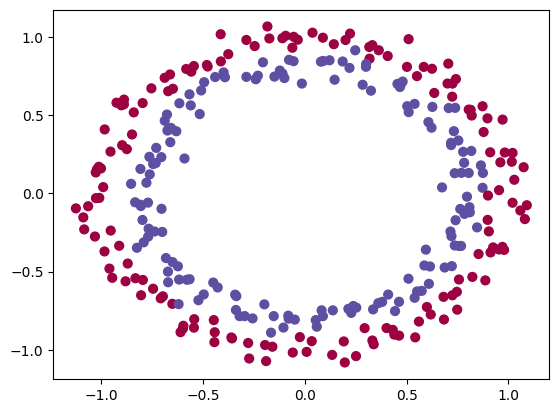

In [5]:
def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

Epoch    50 - 86.52ms/epoch: loss: 0.6558  
Epoch   100 - 42.18ms/epoch: loss: 0.2255  
Epoch   150 - 28.63ms/epoch: loss: 0.0388  
Epoch   200 - 28.30ms/epoch: loss: 0.0148  
Epoch   250 - 29.56ms/epoch: loss: 0.0075  
Epoch   300 - 26.70ms/epoch: loss: 0.0043  
Epoch   350 - 26.54ms/epoch: loss: 0.0027  
Epoch   400 - 27.72ms/epoch: loss: 0.0017  
Epoch   450 - 37.96ms/epoch: loss: 0.0012  
Epoch   500 - 44.62ms/epoch: loss: 0.0008  
Total training time: 18.93 secs


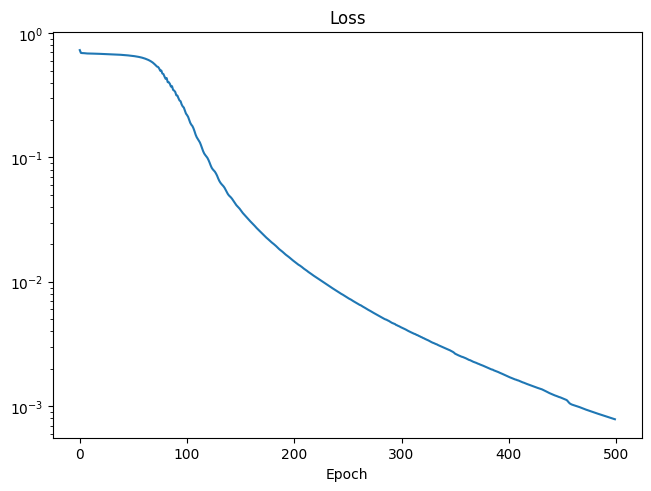

In [76]:
tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=500, batch_size=train_X.shape[0], verbose=0, callbacks=[toolkit.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

In [18]:
model.loss

'binary_crossentropy'

In [19]:
model.metrics

[<Mean name=loss>]

## Custom training loop
First, we'll just check that we can run a custom training loop without any extra processing and confirm that it runs at about the same pace.

Surprisingly, it turns out that my custom training loop runs in about 25% of the time per epoch. The reference implementation contains lots of extra logic, so this must just be python at work when the overheads are multiplied by so many tiny epochs.

Execution mode: autograph
Epoch    50 - 40.69ms/epoch: loss: 0.5842  mse: 0.1970  
Epoch   100 - 8.07ms/epoch: loss: 0.1716  mse: 0.0362  
Epoch   150 - 7.47ms/epoch: loss: 0.0482  mse: 0.0074  
Epoch   200 - 7.74ms/epoch: loss: 0.0221  mse: 0.0027  
Epoch   250 - 7.51ms/epoch: loss: 0.0119  mse: 0.0012  
Epoch   300 - 7.45ms/epoch: loss: 0.0071  mse: 0.0006  
Epoch   350 - 6.95ms/epoch: loss: 0.0046  mse: 0.0003  
Epoch   400 - 7.58ms/epoch: loss: 0.0032  mse: 0.0002  
Epoch   450 - 7.37ms/epoch: loss: 0.0017  mse: 0.0001  
Epoch   500 - 7.36ms/epoch: loss: 0.0010  mse: 0.0000  
Total training time: 5.43 secs


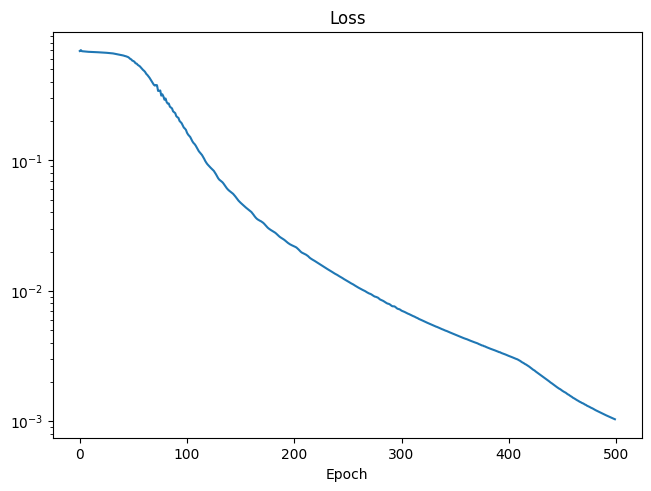

In [73]:
tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(train_X.shape[0])
history = toolkit.fit(model, dataset, epochs=500, verbose=0, callbacks=[toolkit.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")
plot_fit(history)

## Capturing gradients
Now we build out the functionality to capture the gradients

In [119]:
model.trainable_variables

[<KerasVariable shape=(2, 100), dtype=float32, path=sequential_84/dense_504/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_84/dense_504/bias>,
 <KerasVariable shape=(100, 100), dtype=float32, path=sequential_84/dense_505/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_84/dense_505/bias>,
 <KerasVariable shape=(100, 100), dtype=float32, path=sequential_84/dense_506/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_84/dense_506/bias>,
 <KerasVariable shape=(100, 100), dtype=float32, path=sequential_84/dense_507/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_84/dense_507/bias>,
 <KerasVariable shape=(100, 5), dtype=float32, path=sequential_84/dense_508/kernel>,
 <KerasVariable shape=(5,), dtype=float32, path=sequential_84/dense_508/bias>,
 <KerasVariable shape=(5, 1), dtype=float32, path=sequential_84/dense_509/kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=sequential_84/dense_509/bias>]

In [123]:
model.layers

[<Dense name=dense_504, built=True>,
 <Dense name=dense_505, built=True>,
 <Dense name=dense_506, built=True>,
 <Dense name=dense_507, built=True>,
 <Dense name=dense_508, built=True>,
 <Dense name=dense_509, built=True>]

In [124]:
model.layers[0].trainable_variables

[<KerasVariable shape=(2, 100), dtype=float32, path=sequential_84/dense_504/kernel>,
 <KerasVariable shape=(100,), dtype=float32, path=sequential_84/dense_504/bias>]

In [125]:
model.layers[0].trainable_variables[0] in model.trainable_variables

True

In [129]:
model.layers[3].trainable_variables[0]

<KerasVariable shape=(100, 100), dtype=float32, path=sequential_85/dense_513/kernel>

In [131]:
def index_by_identity(lst, target):
  return next((i for i, v in enumerate(lst) if id(v) == id(target)), -1)
#model.trainable_variables.index(model.layers[3].trainable_variables[0])
index_by_identity(model.trainable_variables, model.layers[3].trainable_variables[0])

6

In [184]:
class MyGradientCallback(toolkit.BaseGradientCallback):
    def __init__(self, verbose=1):
      """
      Verbosity levels (to be refactored later):
        1: collects stats on gradients at each step or epoch, but does
           not keep raw gradients.
        2: keeps a sampling of raw gradients
        3: keeps all raw gradients
      """
      super(MyGradientCallback, self).__init__()
      self.verbose = verbose
      self.epochs = []
      self.steps = []  # maybe rename as 'iterations'
      self.model_stats = {}  # dict (by stat) of lists (by iteration)
      self.layer_stats = []  # list (by layer) of dicts (by stat) of lists (by iteration)
      if verbose > 1:
        self.gradients_list = None

      # internal tracking
      self._epoch = 0
      self._variable_indices_by_layer = None

    def on_train_begin(self):
      total_steps = self.params['steps'] * self.params['epochs']

      # init stats
      self.model_stats = {key: [] for key in self._stat_keys()}
      for layer in self.model.layers:
        if layer.trainable_variables:
          self.layer_stats.append({key: [] for key in self._stat_keys()})
        else:
          self.layer_stats.append(None)

      # pre-compute lookups
      self._variable_indices_by_layer = [[]] * len(self.model.layers)
      for l, layer in enumerate(self.model.layers):
        if layer.trainable_variables:
          indices = [self._index_by_identity(self.model.trainable_variables, var) for var in layer.trainable_variables]
          self._variable_indices_by_layer[l] = indices

      if self.verbose > 1:
        self.gradients_list = []

    def on_train_end(self):
      # convert TF values to numpy for easier consumption
      for key in self.model_stats.keys():
        self.model_stats[key] = [v.numpy() for v in self.model_stats[key]]
      for l in range(len(self.layer_stats)):
        if self.layer_stats[l] is not None:
          for key in self.layer_stats[l].keys():
            self.layer_stats[l][key] = [v.numpy() for v in self.layer_stats[l][key]]

    def on_epoch_begin(self, epoch, logs=None):
      self._epoch = epoch
      self.epochs.append(self._epoch)

    def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations=None):
      step = self.params['steps'] * self._epoch + batch
      self.steps.append(step)

      # collect raw gradients
      if self.verbose > 1:
        self.gradients_list.append(gradients)

      # collect stats
      self._append_dict_list(self.model_stats, self._compute_stats(gradients))
      for l, layer in enumerate(self.model.layers):
        # compute stats across all gradients for the given layer
        indices = self._variable_indices_by_layer[l]
        layer_grads = [gradients[i] for i in indices]
        self._append_dict_list(self.layer_stats[l], self._compute_stats(layer_grads))

    def _stat_keys(self):
      return ['mean', 'min', 'max', 'std']

    @tf.function
    def _compute_stats(self, gradients):
      n = tf.constant(0.0, dtype=tf.float32)
      mean = tf.constant(0.0, dtype=tf.float32)
      M2 = tf.constant(0.0, dtype=tf.float32)  # Sum of squared differencse from the mean
      min = tf.constant(float("inf"), dtype=tf.float32)
      max = tf.constant(float("-inf"), dtype=tf.float32)

      for g in gradients:
        g_mags = tf.abs(g)
        g_size = tf.size(g, out_type=tf.float32)
        g_min = tf.reduce_min(g_mags)
        g_max = tf.reduce_max(g_mags)
        g_sum = tf.reduce_sum(g_mags)
        g_mean = g_sum / g_size
        g_var = tf.reduce_sum((g_mags - g_mean)**2)

        min = tf.minimum(min, g_min)
        max = tf.maximum(max, g_max)

        # Welford's algorithm for computing running statistics
        delta = g_mean - mean
        n += g_size
        mean += delta * (g_size / n)
        M2 += g_var + delta**2 * (g_size * (n - g_size) / n)

      return {
          'mean': mean,
          'min': min,
          'max': max,
          'std': tf.sqrt(M2 / n)  # population std.dev
      }

    def _index_by_identity(self, lst, target):
      return next((i for i, v in enumerate(lst) if id(v) == id(target)), -1)

    # note: experiments have found that this is faster than trying to optimise it
    # (for example, trying to use TF Variables to store the lists goes considerably
    #  slower - on scale of 40ms vs 14ms per epoch)
    def _append_dict_list(self, dic, addendum_dict):
      for key in addendum_dict.keys():
        dic[key].append(addendum_dict[key])


def list_gradients(gradients_list):
  print(f"Gradients_list:")
  print(f"  list shape: {len(gradients_list)} x {len(gradients_list[0])} of {type(gradients_list[0][0])}")
  for l in range(len(gradients_list[0]) // 2):
    print(f"  layer {l:2}:  weights: {gradients_list[0][l*2].shape} of {gradients_list[0][l*2].dtype}, bias: {gradients_list[0][l*2+1].shape} of {gradients_list[0][l*2+1].dtype}")

  for e in range(len(gradients_list)):
    print(f"Step {e}:")
    for l in range(len(gradients_list[0]) // 2):
      w_mean = tf.reduce_mean(tf.abs(gradients_list[e][l*2]))
      w_min = tf.reduce_min(tf.abs(gradients_list[e][l*2]))
      w_max = tf.reduce_max(tf.abs(gradients_list[e][l*2]))
      w_std = tf.math.reduce_std(tf.abs(gradients_list[e][l*2]))
      b_mean = tf.reduce_mean(tf.abs(gradients_list[e][l*2+1]))
      b_min = tf.reduce_min(tf.abs(gradients_list[e][l*2+1]))
      b_max = tf.reduce_max(tf.abs(gradients_list[e][l*2+1]))
      b_std = tf.math.reduce_std(tf.abs(gradients_list[e][l*2+1]))
      print(f"  layer {l:2}:  weights: mean: {w_mean:.5f}, min: {w_min:.5f}, max: {w_max:.5f}, std: {w_std:.5f},  bias: mean: {b_mean:.5f}, min: {b_min:.5f}, max: {b_max:.5f}, std: {b_std:.5f}")
      #print(f"  layer {l:2}:  weights: mean: {mean:.5f}, min: {min:.5f}, max: {max:.5f}, std: {std:.5f}")

def plot_gradients(gradients_cb):
  steps = gradients_cb.steps

  mean = np.numpy(gradients_cb.model_stats['mean'])
  std = np.numpy(gradients_cb.model_stats['std'])

  plt.plot(steps, gradients_cb.model_stats['mean'], label='mean')
  #plt.plot(steps, gradients_cb.model_stats['mean'] - gradients_cb.model_stats['std'], label='std')
  plt.plot(steps, gradients_cb.model_stats['min'], label='min')
  plt.plot(steps, gradients_cb.model_stats['max'], label='max')
  plt.fill_between(steps, mean - std, mean + std, color='blue', alpha=0.2, label='std')
  plt.legend()
  plt.show()


def list_stats(gradients_cb):
  print(f"Gradients callback summary:")
  print(f"  Epochs: {len(gradients_cb.epochs)} ({gradients_cb.epochs[0]} .. {gradients_cb.epochs[-1]}), "
      f"steps: {len(gradients_cb.steps)} ({gradients_cb.steps[0]} .. {gradients_cb.steps[-1]})")
  print(f"Model:")
  for key in gradients_cb.model_stats.keys():
    stats = gradients_cb.model_stats[key]
    print(f"  {key:4} ({len(stats)}): {stats[0:3]} .. {stats[-3:]}")
  for l in range(len(gradients_cb.layer_stats)):
    if gradients_cb.layer_stats[l] is not None:
      print(f"Layer {l}:")
      for key in gradients_cb.layer_stats[l].keys():
        stats = gradients_cb.layer_stats[l][key]
        print(f"  {key:4} ({len(stats)}): {stats[0:3]} .. {stats[-3:]}")




reload(toolkit)
tf.config.run_functions_eagerly(False)
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(train_X.shape[0])
gradients = MyGradientCallback()
history = toolkit.fit(model, dataset, epochs=1000, verbose=0, callbacks=[toolkit.LessVerboseProgressLogger()], gradient_callback=gradients)
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

#list_gradients(gradients.gradients_list)
list_stats(gradients)



Execution mode: autograph


Epoch   100 - 39.78ms/epoch: loss: 0.1742  mse: 0.0364  
Epoch   200 - 23.23ms/epoch: loss: 0.0152  mse: 0.0019  
Epoch   300 - 21.46ms/epoch: loss: 0.0044  mse: 0.0003  
Epoch   400 - 14.31ms/epoch: loss: 0.0016  mse: 0.0001  
Epoch   500 - 14.55ms/epoch: loss: 0.0009  mse: 0.0000  
Epoch   600 - 14.12ms/epoch: loss: 0.0005  mse: 0.0000  
Epoch   700 - 14.48ms/epoch: loss: 0.0003  mse: 0.0000  
Epoch   800 - 14.72ms/epoch: loss: 0.0002  mse: 0.0000  
Epoch   900 - 14.27ms/epoch: loss: 0.0002  mse: 0.0000  
Epoch  1000 - 24.01ms/epoch: loss: 0.0001  mse: 0.0000  
Total training time: 19.74 secs
Gradients callback summary:
  Epochs: 1000 (0 .. 999), steps: 1000 (0 .. 999)
Model:
  mean (1000): [0.000689691, 0.0013005399, 0.00038894665] .. [3.5644719e-06, 2.1038222e-06, 4.184567e-06]
  min  (1000): [0.0, 0.0, 0.0] .. [0.0, 0.0, 0.0]
  max  (1000): [0.077658325, 0.12547716, 0.06397772] .. [0.00043577535, 0.00042840707, 0.0007378075]
  std  (1000): [0.0013693167, 0.003125162, 0.00092446536

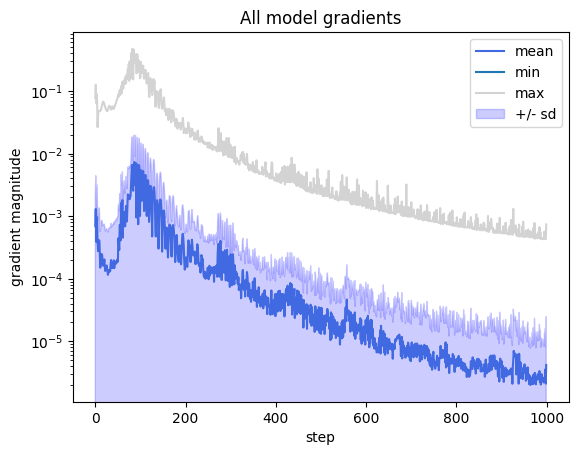

In [190]:
def plot_gradients(gradients_cb):
  steps = gradients_cb.steps

  mean = np.array(gradients_cb.model_stats['mean'])
  std = np.array(gradients_cb.model_stats['std'])

  plt.plot(steps, gradients_cb.model_stats['mean'], label='mean', color='royalblue')
  plt.plot(steps, gradients_cb.model_stats['min'], label='min')
  plt.plot(steps, gradients_cb.model_stats['max'], label='max', color='lightgray')
  plt.fill_between(steps, mean - std, mean + std, color='blue', alpha=0.2, label='+/- sd')
  plt.yscale('log')
  plt.xlabel('step')
  plt.ylabel('gradient magnitude')
  plt.title('All model gradients')
  plt.legend()
  plt.show()

plot_gradients(gradients)

In [167]:
a = []
a[3] = 4

IndexError: list assignment index out of range

In [152]:
v = tf.Variable(tf.zeros((10,)), dtype=tf.float32)
v[2].assign(3.0)
v

<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=array([0., 0., 3., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [80]:
model.losses

[]

## Appendix: Prove out maths behind implementation of Welford's algorithm

In [118]:
def _compute_stats_numpy(gradients):
  mags = [tf.abs(g).numpy() for g in gradients]
  mags = np.stack(mags)
  print(f"numpy, mags: {mags.shape}")
  return {
      'mean': np.mean(mags),
      'min': np.min(mags),
      'max': np.max(mags),
      'std': np.std(mags)
  }

def _compute_stats_brute(gradients):
  mags = [tf.abs(g) for g in gradients]
  mags = tf.stack(mags)
  return {
      'mean': tf.reduce_mean(mags).numpy(),
      'min': tf.reduce_min(mags).numpy(),
      'max': tf.reduce_max(mags).numpy(),
      'std': tf.math.reduce_std(mags).numpy()
  }

def _compute_stats(gradients):
  n = tf.constant(0.0, dtype=tf.float32)
  mean = tf.constant(0.0, dtype=tf.float32)
  M2 = tf.constant(0.0, dtype=tf.float32)  # Sum of squared differencse from the mean
  min = None
  max = None

  # TODO: sanity check this against brute-force approach
  for g in gradients:
    g_mags = tf.abs(g)
    g_size = tf.size(g, out_type=tf.float32)
    g_min = tf.reduce_min(g_mags)
    g_max = tf.reduce_max(g_mags)
    g_sum = tf.reduce_sum(g_mags)
    g_mean = g_sum / g_size
    g_var = tf.reduce_sum((g_mags - g_mean)**2)

    if min == None or g_min < min:
      min = g_min
    if max == None or g_max > max:
      max = g_max

    # Welford's algorithm for computing running statistics
    delta = g_mean - mean
    n += g_size
    mean += delta * (g_size / n)
    M2 += g_var + delta**2 * (g_size * (n - g_size) / n)

  if n > 1:
    return {
        'mean': mean.numpy(),
        'min': min.numpy(),
        'max': max.numpy(),
        'std': tf.sqrt(M2 / n).numpy()
    }
  else:
    return {
        'mean': 0.0,
        'min': 0.0,
        'max': 0.0,
        'std': 0.0
    }


gradients = [
    tf.constant([0.1, 0.2, 0.3]),
    tf.constant([0.4, 0.5, 0.6]),
    tf.constant([0.7, 0.8, 0.9]),
]

print(f"numpy:     {_compute_stats_numpy(gradients)}")
print(f"brute:     {_compute_stats_brute(gradients)}")
print(f"efficient: {_compute_stats(gradients)}")

numpy, mags: (3, 3)
numpy:     {'mean': 0.5, 'min': 0.1, 'max': 0.9, 'std': 0.2581989}
brute:     {'mean': 0.5, 'min': 0.1, 'max': 0.9, 'std': 0.2581989}
efficient: {'mean': 0.5, 'min': 0.1, 'max': 0.9, 'std': 0.2581989}
